**P7 PROJECT: Problematic subgroup research on textual data**

Metodology application on IMBD DATASET

# Parte 1

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, set_seed
import torch
from torch.utils.data import Dataset
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
# set seeds for reproducibility
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

set_global_seed(42)

In [ ]:
# nltk stopwords
nltk.download('stopwords')
nltk.download('punkt')

# spacy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**STEP ONE**
Dataset loading, preprocessing and predictions

In [ ]:
df = pd.read_csv('10K_imdb_dataset.csv')

In [ ]:
# Preprocessing
# Remove numbers, Convert text to lowercase, Remove URLs, Remove punctuation,
# Tokenize text, Remove stopwords, Reconstruct text, Lemmatize text, Remove extra whitespace
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    text = ' '.join(words)
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    text = ' '.join(text.split())
    return text
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [ ]:
#test train spleet
X_train, X_test, y_train, y_test = train_test_split(df[['text', 'preprocessed_text']], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Funzione per tokenizzare e codificare i dati
def encode_data(texts, tokenizer, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenize and encode data
train_encodings = encode_data(X_train['preprocessed_text'], tokenizer)
test_encodings = encode_data(X_test['preprocessed_text'], tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Define IMDbDataset
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

y_train_encoded = y_train.tolist()
y_test_encoded = y_test.tolist()

train_dataset = IMDbDataset(train_encodings, y_train_encoded)
test_dataset = IMDbDataset(test_encodings, y_test_encoded)

In [ ]:
!pip install accelerate -U

# Parte 2

In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# training parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    seed=42,
    learning_rate=1e-6,
    save_total_limit=1,
    load_best_model_at_end=True
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the modeld
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.520400,0.497016
2,0.458500,0.360608
3,0.396600,0.346765


TrainOutput(global_step=3000, training_loss=0.48916922410329183, metrics={'train_runtime': 2491.9689, 'train_samples_per_second': 9.631, 'train_steps_per_second': 1.204, 'total_flos': 6314665328640000.0, 'train_loss': 0.48916922410329183, 'epoch': 3.0})

In [ ]:
#get predictions
predictions = trainer.predict(test_dataset)
predicted_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

In [ ]:
#add predictions and their probability on test dataset
pred_labels = predictions.predictions.argmax(axis=1)
pred_probs = predicted_probs.max(dim=1).values
# new dataframe with: original data, the prediction and the probability for the test set
result_df = pd.DataFrame({
    'text': X_test['text'],
    'preprocessed_text': X_test['preprocessed_text'],
    'label': y_test.tolist(),
    'prediction': pred_labels.tolist(),
    'probability': pred_probs.tolist()
})
result_df['probability'] = result_df['probability'].round(2)

In [ ]:
result_df.to_csv('10K_predictions_with_preprocessed_text_prob2.csv', index=False)

**STEP TWO**
p* research and metadata addition

In [ ]:
!pip install datasets
!pip install datasets nltk spacy scikit-learn textstat
!pip install spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00


In [ ]:
import random
import nltk
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import flesch_reading_ease
import string
from textstat.textstat import textstatistics
from sklearn.preprocessing import MinMaxScaler

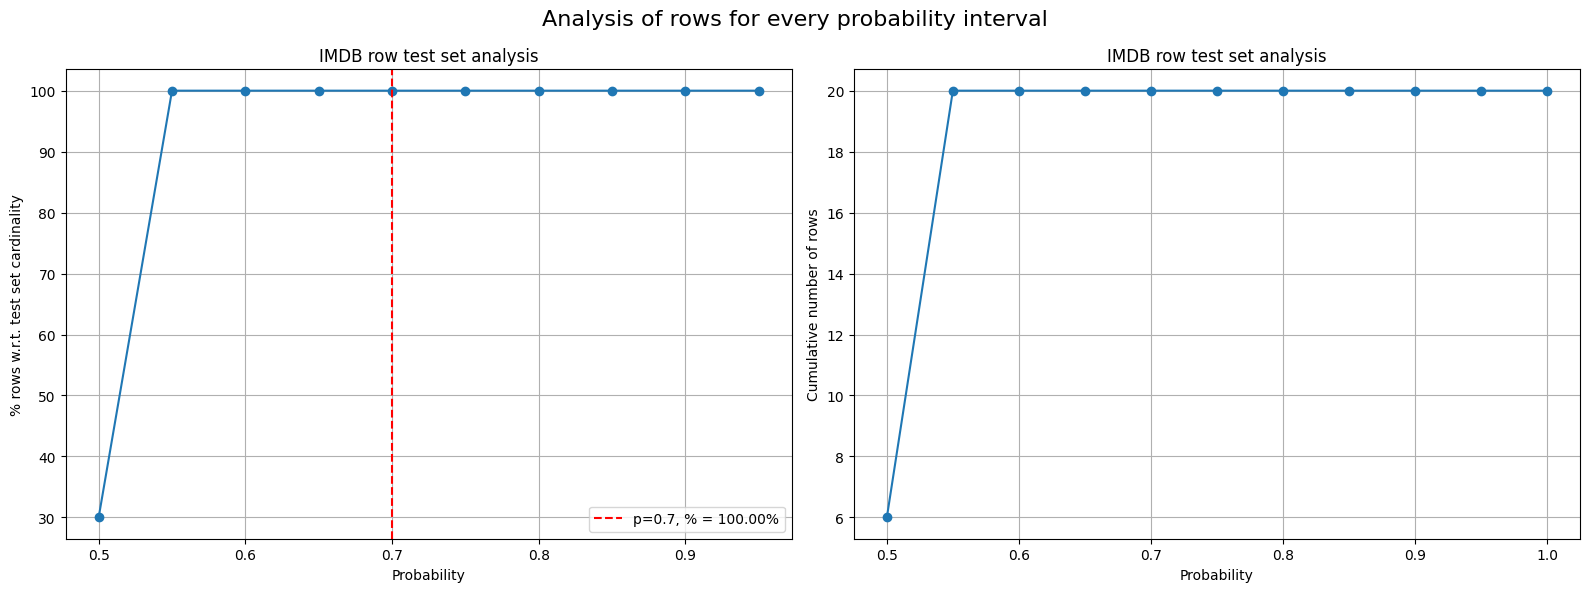

% rows p=0.7: 100.00%


In [ ]:
# % rows for every prob interval
x_percentuale = np.arange(0.5, 1, 0.05)
y_percentuale = np.zeros(len(x_percentuale))
for i in range(len(x_percentuale)):
    y_percentuale[i] = ((result_df['probability'] <= x_percentuale[i]).sum() / len(result_df)) * 100  # % computation

# #rows for every interval
x_numero = np.arange(0.5, 1.05, 0.05)
y_numero = np.zeros(len(x_numero), dtype=int)
for i in range(len(x_numero)):
    y_numero[i] = (result_df['probability'] <= x_numero[i]).sum()  # #rows

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: % rows for every prob interval
ax1.plot(x_percentuale, y_percentuale, marker='o', linestyle='-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('% rows w.r.t. test set cardinality')
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.set_title('IMDB row test set analysis')

# % closer to a p=0.7
indice_x_07 = np.abs(x_percentuale - 0.7).argmin()
percentuale_x_07 = y_percentuale[indice_x_07]
ax1.axvline(x=x_percentuale[indice_x_07], color='red', linestyle='--', label=f'p=0.7, % = {percentuale_x_07:.2f}%')
ax1.legend()

# #rows for interval
ax2.plot(x_numero, y_numero, marker='o', linestyle='-')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Cumulative number of rows')
ax2.tick_params(axis='y')
ax2.grid(True)
ax2.set_title('IMDB row test set analysis')

fig.suptitle('Analysis of rows for every probability interval', fontsize=16)
fig.tight_layout()
plt.show()
print(f"% rows p=0.7: {percentuale_x_07:.2f}%")

In [ ]:
df = pd.read_csv('10K_predictions_with_preprocessed_text_prob2.csv')

The dataset contains movie reviews and related sentiment (positive = 1 and negative = 0).

Starting from these 10 thousand reviews, we want to build a dataframe with features given by some statistics

Let's start with features generated from statistics, we will have:


* words: number of words
* num_chars: number of characters
* sentences: number of sentences
* avg_word_length: average word length
* avg_sentence_length: average sentence length
* num_punct: sum of number of commas, periods, semicolons and exclamation points
* NER: number of named entities
* readability: readability score
* TF-IDF(20): Term frequency-inverse document frequency for specific words

In [ ]:
# Load the spaCy model for named entity recognition
nlp = spacy.load("en_core_web_sm")

# Function to count the number of words
def count_words(text):
    if pd.isnull(text):
        return 0
    return len(text.split())

# Function to count the number of characters
def count_chars(text):
    if pd.isnull(text):
        return 0
    return len(text)

# Function to count the number of sentences
def count_sentences(text):
    if pd.isnull(text):
        return 0
    return len(text.split('.'))

# Function to calculate the average word length
def avg_word_length(text):
    if pd.isnull(text):
        return 0
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

# Function to calculate the average sentence length
def avg_sentence_length(text):
    if pd.isnull(text):
        return 0
    sentences = text.split('.')
    words = text.split()
    return len(words) / len(sentences) if sentences else 0

# Function to count the number of punctuation marks
def count_punct(text):
    if pd.isnull(text):
        return 0
    return sum(1 for char in text if char in ',;.!')

# Function to count the number of named entities
def count_ner(text):
    if pd.isnull(text):
        return 0
    doc = nlp(text)
    return len(doc.ents)

# Function to calculate the readability score
def readability_score(text):
    if pd.isnull(text):
        return 0
    return textstatistics().flesch_reading_ease(text)

# Apply the functions to create new columns
df['num_words'] = df['text'].apply(count_words)
df['num_chars'] = df['text'].apply(count_chars)
df['sentences'] = df['text'].apply(count_sentences)
df['avg_word_length'] = df['text'].apply(avg_word_length).round(2)
df['avg_sentence_length'] = df['text'].apply(avg_sentence_length).round(2)
df['num_punct'] = df['text'].apply(count_punct).round(2)
df['NER'] = df['text'].apply(count_ner).round(2)
df['readability'] = df['text'].apply(readability_score).round(2)

# Display the updated DataFrame
print(df)


                                                 text  \
0   I enjoyed Still Crazy more than any film I hav...   
1   I paid attention and enjoyed the very rich exp...   
2   "I'll Take You There" tells of a woebegone man...   
3   I can remember reading that Darwin had a pivot...   
4   I can appreciate satire that goes against my o...   
5   The original "Psycho" (1960) is widely conside...   
6   EARTH (2009) ***1/2 Big screen adaptation of t...   
7   Great. Another foreign film that thinks it's F...   
8   I wasn't at all a fan of the 2005 gore fest hi...   
9   This was just another marvelous film of the Be...   
10  It got to be a running joke around Bonanza abo...   
11  British comedies tend to fall into one of two ...   
12  It takes a Serbian or at least a Balkan famili...   
13  I cry at a lot of movies. Call me sentimental....   
14  I watched this film on ITV and I enjoyed it a ...   
15  This is without doubt the worst film in the Ha...   
16  If you have ever babysat in

In [ ]:
#FOR TF-IDF
# List of selected words
selected_words = [
    "love", "great", "excellent", "amazing", "awesome", "fantastic", "enjoyed", "best",
    "wonderful", "favorite", "bad", "worst", "boring", "terrible", "awful",
    "disappointing", "waste", "poor", "hate", "mediocre"
]

# Initialize the TfidfVectorizer with the selected words as vocabulary
vectorizer = TfidfVectorizer(vocabulary=selected_words)

# Fit and transform the 'text' column
tfidf_matrix = vectorizer.fit_transform(df['text'].fillna(""))

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add the TF-IDF columns to the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)
# Function to count occurrences of each word in the text column
def count_word_occurrences(word, text_series):
    return text_series.str.contains(f'\\b{word}\\b', case=False, na=False).sum()

# Create a dictionary to store the counts
word_counts = {word: count_word_occurrences(word, df['text']) for word in selected_words}

# Display the counts
for word, count in word_counts.items():
    print(f"'{word}' appears in {count} rows")


'love' appears in 2 rows
'great' appears in 4 rows
'excellent' appears in 0 rows
'amazing' appears in 1 rows
'awesome' appears in 1 rows
'fantastic' appears in 1 rows
'enjoyed' appears in 5 rows
'best' appears in 2 rows
'wonderful' appears in 1 rows
'favorite' appears in 0 rows
'bad' appears in 4 rows
'worst' appears in 2 rows
'boring' appears in 0 rows
'terrible' appears in 1 rows
'awful' appears in 0 rows
'disappointing' appears in 0 rows
'waste' appears in 0 rows
'poor' appears in 0 rows
'hate' appears in 1 rows
'mediocre' appears in 1 rows


In [ ]:
# Add 'uncertainty' feature
df['uncertainty'] = (df['probability'] <= 0.7).astype(int)

In [ ]:
column_order = ['text', 'num_words', 'num_chars', 'sentences', 'avg_word_length', 'avg_sentence_length',
                'num_punct', 'NER', 'readability'] + selected_words + ['prediction', 'probability', 'uncertainty', 'label']

In [ ]:
df = df[column_order]
df.head(5)

,text,num_words,num_chars,sentences,avg_word_length,avg_sentence_length,num_punct,NER,readability,love,...,awful,disappointing,waste,poor,hate,mediocre,prediction,probability,uncertainty,label
0,I enjoyed Still Crazy more than any film I hav...,89,494,7,4.56,12.71,11,3,75.61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.51,1,1
1,I paid attention and enjoyed the very rich exp...,162,963,11,4.95,14.73,18,6,63.59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.51,1,1
2,"""I'll Take You There"" tells of a woebegone man...",70,412,4,4.90,17.50,6,2,64.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.50,1,1
3,I can remember reading that Darwin had a pivot...,203,1187,16,4.85,12.69,26,8,64.10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.50,1,0
4,I can appreciate satire that goes against my o...,138,881,14,5.39,9.86,27,1,58.79,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.50,1,0


In [ ]:
df.to_csv("2K_film_metatdata_and_uncertainty_to_preprocess_and_DivExp.csv", index = False)

**STEP THREE** Data discretization and DivExplorer

In [ ]:
df = pd.read_csv('2K_film_metatdata_and_uncertainty_to_preprocess_and_DivExp.csv')

In [ ]:
valori_univoci = df['uncertainty'].unique()
print(valori_univoci)

[1]


In [ ]:
#normalize TF-IDF to have interpretability
features_to_scale = [
    "love", "great", "excellent", "amazing", "awesome", "fantastic", "enjoyed", "best",
    "wonderful", "favorite", "bad", "worst", "boring", "terrible", "awful",
    "disappointing", "waste", "poor", "hate", "mediocre", "readability"
]

# Creazione di un oggetto MinMaxScaler
scaler = MinMaxScaler()

# Normalizzazione delle colonne selezionate utilizzando MinMaxScaler
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df[features_to_scale] = df[features_to_scale].applymap(lambda x: round(x, 2))

In [ ]:
max_min_values = df['num_words'].agg(['max', 'min'])

print("Valori massimi e minimi di ogni colonna:")
print(max_min_values)
#discretization
bins = [20, 268, 515, 762, 1009]
labels = ['very short', 'short', 'long', 'very long']
df['#words'] = pd.cut(df['num_words'], bins=bins, labels=labels)
df.drop(columns=['num_words'], inplace=True)

Valori massimi e minimi di ogni colonna:
max    554
min     70
Name: num_words, dtype: int64


In [ ]:
#similar for the other features
bins = [120, 1618, 3114, 4610, 7000]
labels = ['very short', 'short', 'long', 'very long']
df['#chars'] = pd.cut(df['num_chars'], bins=bins, labels=labels)
df.drop(columns=['num_chars'], inplace=True)
bins = [1, 25, 50, 75, 110]
labels = ['very short', 'short', 'long', 'very long']
df['#_sent'] = pd.cut(df['sentences'], bins=bins, labels=labels)
df.drop(columns=['sentences'], inplace=True)
bins = [3, 4, 5, 6, 7]
labels = ['very short', 'short', 'long', 'very long']
df['avg_w_l'] = pd.cut(df['avg_word_length'], bins=bins, labels=labels)
df.drop(columns=['avg_word_length'], inplace=True)
bins = [1, 50, 100, 150, 201]
labels = ['very short', 'short', 'long', 'very long']
df['avg_s_l'] = pd.cut(df['avg_sentence_length'], bins=bins, labels=labels)
df.drop(columns=['avg_sentence_length'], inplace=True)
bins = [1, 45, 90, 130, 155]
labels = ['very short', 'short', 'long', 'very long']
df['#_punct'] = pd.cut(df['num_punct'], bins=bins, labels=labels)
df.drop(columns=['num_punct'], inplace=True)
bins = [0, 20, 40, 60, 85]
labels = ['very short', 'short', 'long', 'very long']
df['#NER'] = pd.cut(df['NER'], bins=bins, labels=labels)
df.drop(columns=['NER'], inplace=True)
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['very short', 'short', 'long', 'very long']
df['readability_'] = pd.cut(df['readability'], bins=bins, labels=labels)
df.drop(columns=['readability'], inplace=True)

In [ ]:
!pip install divexplorer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00


In [ ]:
list_ = ['text', 'love', 'great', 'excellent', 'amazing', 'awesome', 'fantastic', 'enjoyed', 'best', 'wonderful', 'probability', 'prediction',  'favorite', 'bad', 'worst', 'boring', 'terrible', 'awful', 'disappointing', 'waste', 'poor', 'hate', 'mediocre', 'label']
df.drop(columns=list_, inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from divexplorer import DivergenceExplorer
fp_diver = DivergenceExplorer(df)
#attributes = ['avg_s_l', '#chars', '#_sent', '#_punct', '#NER', 'readability_']
subgroups = fp_diver.get_pattern_divergence(min_support=0.1,  boolean_outcomes=["uncertainty"])
subgroups = subgroups.sort_values(by="uncertainty_div", ascending=False, ignore_index=True)
subgroups.head(10)

,support,itemset,uncertainty,uncertainty_div,uncertainty_t,length,support_count
0,1.00,(avg_s_l=very short),1.0,0.0,0.000000,1,20.0
1,0.15,"(#_sent=very short, #words=very short, readability_=very long, #NER=very short, avg_w_l=short, #_punct=very short)",1.0,0.0,0.914596,6,3.0
2,0.15,"(#words=very short, avg_w_l=short, readability_=very long)",1.0,0.0,0.914596,3,3.0
3,0.15,"(#words=very short, readability_=very long)",1.0,0.0,0.914596,2,3.0
4,0.15,"(#_sent=very short, #words=very short, readability_=very long, avg_s_l=very short, #chars=very short, #_punct=very short)",1.0,0.0,0.914596,6,3.0
5,0.15,"(#words=very short, readability_=very long, #NER=very short, avg_s_l=very short, #chars=very short, #_punct=very short)",1.0,0.0,0.914596,6,3.0
6,0.15,"(#_sent=very short, #words=very short, readability_=very long, #NER=very short, avg_s_l=very short, #chars=very short)",1.0,0.0,0.914596,6,3.0
7,0.15,"(#_sent=very short, #words=very short, readability_=very long, #NER=very short, avg_s_l=very short, #_punct=very short)",1.0,0.0,0.914596,6,3.0
8,0.15,"(#_sent=very short, #words=very short, readability_=very long, avg_w_l=short, #chars=very short, #_punct=very short)",1.0,0.0,0.914596,6,3.0
9,0.15,"(#words=very short, readability_=very long, #NER=very short, avg_w_l=short, avg_s_l=very short, #chars=very short, #_punct=very short)",1.0,0.0,0.914596,7,3.0


In [ ]:
from divexplorer import DivergencePatternProcessor
fp_details = DivergencePatternProcessor(subgroups, 'uncertainty')

# We can pick a pattern
pattern = fp_details.patterns['itemset'].iloc[0]
print(pattern)

# and compute the Shapley value of the items.
sv = fp_details.shapley_value(pattern)
sv

frozenset({'avg_s_l=very short'})


{frozenset({'avg_s_l=very short'}): 0.0}

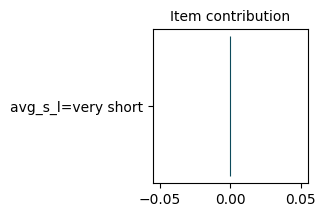

In [ ]:
fp_details.plot_shapley_value(pattern = pattern, figsize=(2,2), title="Item contribution")